In [1]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from torchvision import models, transforms
import torch
# import pretrainedmodels
# import pretrainedmodels.utils as utils


In the below step, we, 
* Load the image
* Convert the image to RGB channel
* Transform the image -
  * Convert to PIL format
  * Resize to lower resolution
  * Convert to tensor dtype
  * Normalize the pixel values
* Unsqueeze the image to add a batch dimension
* Define a dataloader to load single image

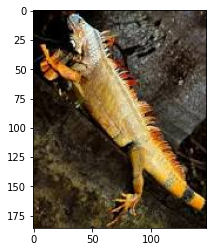

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


In [2]:
# read and visualize an image
path_to_img = '/content/Iguana.jpeg'
img = cv.imread(path_to_img) # Insert the path to image.
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
# define the transforms
# use the ImageNet transformation
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

arr_img = np.array(img)
# apply the transforms
trans_img = transform(arr_img)
print(trans_img.size())
# unsqueeze to add a batch dimension
trans_img = trans_img.unsqueeze(0)
print(trans_img.size())

# # define the dataloader to load that single image
dataloader = data.DataLoader(dataset=trans_img, shuffle=False, batch_size=1)

Defining a GradCam model

* We are using hooks to get the activation maps and the gradients from the desired layer and tensor, respectively. 
* For this tutorial, we are going to take the activation maps from layer4 of ResNet50 and gradients with respect to the output tensor of the same.

In [3]:
class GradCamModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.gradients = None
        self.tensorhook = []
        self.layerhook = []
        self.selected_out = None
        
        #PRETRAINED MODEL
        self.pretrained = models.resnet50(weights = 'DEFAULT') # IMAGENET1K_V1
        self.layerhook.append(self.pretrained.layer4.register_forward_hook(self.forward_hook()))
        
        for p in self.pretrained.parameters():
            p.requires_grad = True
    
    def activations_hook(self,grad):
        self.gradients = grad

    def get_act_grads(self):
        return self.gradients

    def forward_hook(self):
        def hook(module, inp, out):
            self.selected_out = out
            self.tensorhook.append(out.register_hook(self.activations_hook))
        return hook

    def forward(self,x):
        out = self.pretrained(x)
        return out, self.selected_out

First, we make the forward pass through the network with the image and see what the RESNET50 predicts. 

In [32]:
gcmodel = GradCamModel()
gcmodel.eval()
out, acts = gcmodel(trans_img)

In [33]:
predClass = out.argmax(dim=1)
predClass

tensor([39])

Click the below link to identify the class name.

https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/

Now, we are going to do the back-propagation with the logit of the predicted class in the ImageNet dataset.

Grad-CAM uses the feature maps produced by the last convolutional layer of a CNN. The authors of Grad-CAM argue, “we can expect the last convolutional layers to have the best compromise between high-level semantics and detailed spatial information.”

Grad-CAM is applied to a neural network that is done training. The weights of the neural network are fixed. We feed an image into the network to calculate the Grad-CAM heatmap for that image for a chosen class of interest.

Grad-CAM Details

Let us assume $y^c$ is the score for class $c$ i.e., the output for class $c$ before the softmax.

Step 1: Computing Gradient
  * Compute the gradient of $y^c$ with respect to the feature map activation $A^k$ of a convolution layer i.e., $\frac {∂y^c}{∂A^k}$

Step 2: Calculate Global Average Pooling ( GAP ) of the feature map.
  * Global average pool the gradients over the width dimension (indexed by $i$) and the height dimension (indexed by $j$) to obtain neuron importance weights ${\alpha_k^c}$

  $
  {\alpha_k^c} = \frac {1}{Z} \sum_{i} \sum_{j} \frac {∂y^c}{∂A^k_{ij}}
  $

Step 3: Calculate Final Grad-CAM Heatmap
  * Perform a weighted combination of the feature map activations $A^k$ where the weights are the ${\alpha_k^c}$ just calculated.

  $
  L^c_{Grad-CAM} = ReLU (\sum_k {\alpha_k^c} A^k)
  $


In [6]:
acts.shape

torch.Size([1, 2048, 7, 7])

In [34]:
# Cack-propagation with the logit of the predicted class
loss = nn.CrossEntropyLoss()(out,torch.from_numpy(np.array(predClass)))
loss.backward()

# Step 1 - Gradient of output y wrt to activation map
grads = gcmodel.get_act_grads().detach() 

# #Step 2 - Global Average Pooling 
pooled_grads = torch.mean(grads, dim=[0,2,3]).detach() # 

# Step 3 - Weighted combination of influence and feature maps
for i in range(acts.shape[1]):
 acts[:,i,:,:] += pooled_grads[i]
heatmap_j = torch.mean(acts, dim = 1).squeeze()

heatmap_j_max = heatmap_j.max(axis = 0)[0] 
# heatmap_j_max = torch.maximum(heatmap_j,torch.zeros(heatmap_j.size()))  # Adding ReLU
heatmap_j /= heatmap_j_max # Normalizing 
heatmap_j = heatmap_j.detach().numpy()

Visualizing the heat maps, Grad-CAM heat-map projected onto the original image and the original image.

First step is to superimpose the heatmaps into original image.

In [45]:
heatmap = cv.resize(heatmap_j, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv.applyColorMap(heatmap, cv.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + 0.6 * img # alpha = 0.4 - Transparency factor
# superimposed_img = torch.uint8()
# cv.imwrite('./map.jpg', superimposed_img)


Text(0.5, 1.0, 'Original image')

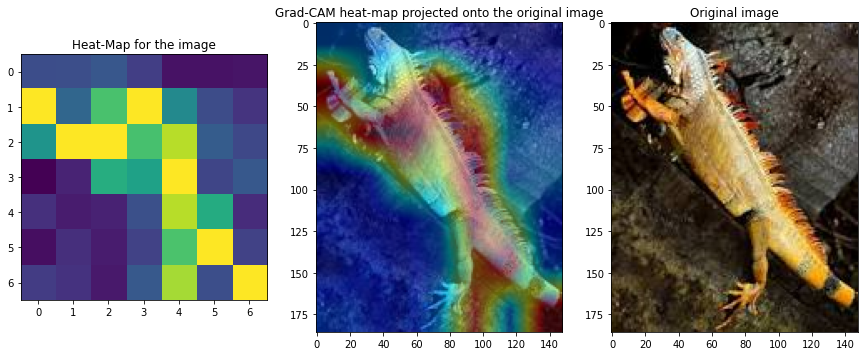

In [46]:
# superimposed_img = cv.imread('/content/map.jpg') # Imaging conventions
superimposed_img = cv.cvtColor(superimposed_img.astype(np.uint8), cv.COLOR_BGR2RGB)
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(heatmap_j.squeeze())
plt.title('Heat-Map for the image')
plt.subplot(132)
plt.imshow(superimposed_img)
plt.title('Grad-CAM heat-map projected onto the original image')
plt.subplot(133)
plt.imshow(img)
plt.title('Original image')
